## ECE219 Project 1

#### Question 1: Hostogram

In [1]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')
print("Number of documents in Training set:",len(newsgroups_train.data))
print("Number of target in Training set:",len(newsgroups_train.target))

Number of documents in Training set: 11314
Number of target in Training set: 11314


In [2]:
# Plot the histogram of the target category in Training set
import numpy as np
import matplotlib.pyplot as plt
#count number and id
num_target = {}
for num in newsgroups_train.target:
    if num not in num_target:
        num_target[num] = 1
    else:
        num_target[num] += 1
#match target name and counts
name_target = {}
for i in range(len(newsgroups_train.target_names)):
    name_target[newsgroups_train.target_names[i]] = num_target[i]

objects = list(name_target.keys())
x = np.arange(len(objects))
counts = name_target.values()
plt.figure(figsize=(32,16))
plt.xticks(x, objects,rotation = 90,fontsize=20)
plt.yticks(fontsize=20)
plt.bar(x, counts, align='center', alpha=0.5)
plt.xlabel('Target Name',fontsize=30)
plt.ylabel('Counts',fontsize=30)
plt.title('Target Histogram',fontsize=30)
plt.show()

<Figure size 3200x1600 with 1 Axes>

### Binary Classification
#### 1 Feature Extraction
#### Question 2: TF-IDF

In [4]:
import random
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
import re
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

computer_technology = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
recreational_activity = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
train_dataset = fetch_20newsgroups(subset = 'train', categories = computer_technology + recreational_activity, shuffle = True, random_state = 42, remove=('headers', 'footers', 'quotes'))
test_dataset = fetch_20newsgroups(subset = 'test', categories = computer_technology + recreational_activity, shuffle = True, random_state = 42, remove=('headers', 'footers', 'quotes'))

#Lemmaitzer
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

##tokenizer
def tokenizer(text):
    wnl = WordNetLemmatizer()
    clean_text = re.sub(r'[^A-Za-z]', " ", text)
    tokenized_text = nltk.word_tokenize(clean_text) 
    lemaitzed_text = [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(tokenized_text)]
    return lemaitzed_text   
    
##tokenizer & vectorize
vectorizer = CountVectorizer(min_df=3, tokenizer=tokenizer, lowercase=True, stop_words='english')
X_train_counts = vectorizer.fit_transform(train_dataset.data)
X_test_counts = vectorizer.transform(test_dataset.data)

##tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)


[nltk_data] Downloading package punkt to /Users/rover/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/rover/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /Users/rover/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/Users/rover/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make', 'u'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [5]:
print("The shape of TF-IDF matrix of training set:",X_train_tfidf.shape)
print("The shape of TF-IDF matrix of testing set:",X_test_tfidf.shape)

The shape of TF-IDF matrix of training set: (4732, 9429)
The shape of TF-IDF matrix of testing set: (3150, 9429)


#### 2. Dimensionality Reduction

#### Question 3: LSI and NMF

In [6]:
#LSI
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, random_state=0)
X_train_reduced = svd.fit_transform(X_train_tfidf)

X_test_reduced = svd.transform(X_test_tfidf)
print("The shape of reduced X_train through LSI:",X_train_reduced.shape)
print("The shape of reduced X_test through LSI:",X_test_reduced.shape)

The shape of reduced X_train through LSI: (4732, 50)
The shape of reduced X_test through LSI: (3150, 50)


In [7]:
#NMF
from sklearn.decomposition import NMF
model = NMF(n_components=50, init='random', random_state=0)
W_train = model.fit_transform(X_train_tfidf)
H = model.components_
W_test = model.transform(X_test_tfidf)
print("The shape of reduced X_train through NMF:",W_train.shape)
print("The shape of reduced X_test through NMF:",W_test.shape)

The shape of reduced X_train through NMF: (4732, 50)
The shape of reduced X_test through NMF: (3150, 50)


In [8]:
import numpy as np
print("Squared residual of NMF is:", np.sum(np.array(X_train_tfidf-W_train.dot(H))**2))
print("Squared residual of LSI is:", np.sum(np.array(X_train_tfidf-X_train_reduced.dot(svd.components_))**2))

Squared residual of NMF is: 3964.7253596155
Squared residual of LSI is: 3922.2617120747036


#### 3 Classification Algorithm

#### Question4: Hard margin and soft margin SVM

In [9]:
#Data preprocessing

# combine original categories into two
computer_technology = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
recreational_activity = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
comp_train = fetch_20newsgroups(subset='train', categories=computer_technology, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
rec_train = fetch_20newsgroups(subset='train', categories=recreational_activity, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
comp_test = fetch_20newsgroups(subset='test', categories=computer_technology, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
rec_test = fetch_20newsgroups(subset='test', categories=recreational_activity, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))

# map to binary classification
all_train = comp_train.data+rec_train.data
all_test = comp_test.data+rec_test.data
target_train = [True] * len(comp_train.data) + [False] * len(rec_train.data)
target_test = [True] * len(comp_test.data) + [False] * len(rec_test.data)

#Lemmaitzer
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

##tokenizer
def tokenizer(text):
    wnl = WordNetLemmatizer()
    clean_text = re.sub(r'[^A-Za-z]', " ", text)
    tokenized_text = nltk.word_tokenize(clean_text) 
    lemaitzed_text = [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(tokenized_text)]
    return lemaitzed_text

##tokenizer & vectorize
vectorizer = CountVectorizer(min_df=3, tokenizer=tokenizer, lowercase=True, stop_words='english')
X_train_counts = vectorizer.fit_transform(all_train)
X_test_counts = vectorizer.transform(all_test)

##tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
print("The shape of TF-IDF matrix of training set:",X_train_tfidf.shape)
print("The shape of TF-IDF matrix of testing set:",X_test_tfidf.shape)

#LSI
svd = TruncatedSVD(n_components=50, random_state=0)
X_train_reduced = svd.fit_transform(X_train_tfidf)
X_test_reduced = svd.transform(X_test_tfidf)
print("The shape of reduced X_train through LSI:",X_train_reduced.shape)
print("The shape of reduced X_test through LSI:",X_test_reduced.shape)


/Users/rover/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make', 'u'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
The shape of TF-IDF matrix of training set: (4732, 9429)
The shape of TF-IDF matrix of testing set: (3150, 9429)
The shape of reduced X_train through LSI: (4732, 50)
The shape of reduced X_test through LSI: (3150, 50)


-------------------- Hard-SVM --------------------
accuracy: 0.5104761904761905
precision: 0.875
recall: 0.013461538461538462
F-1 score: 0.026515151515151516
confusion matrix: [[1587    3]
 [1539   21]]


<Figure size 432x288 with 0 Axes>

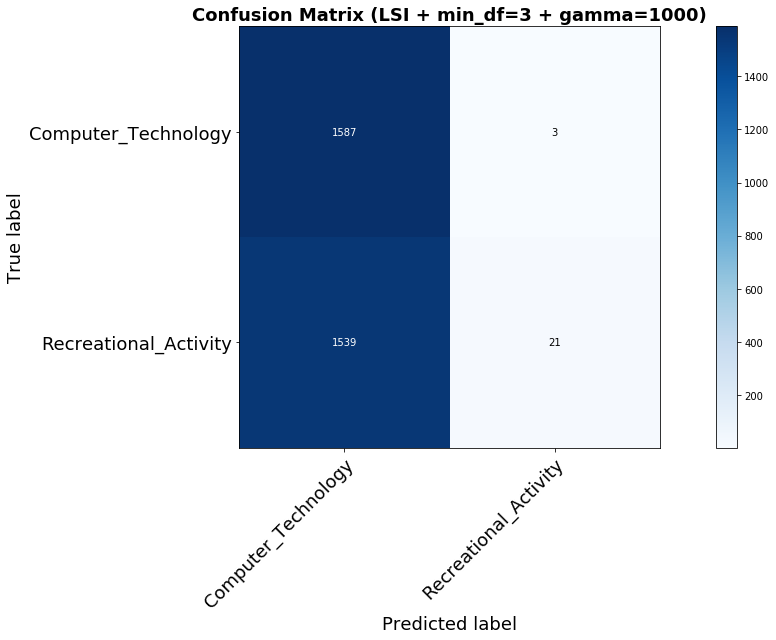

In [10]:
#training SVM
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

#define confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,title,cmap=plt.cm.Blues, normalize=False):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,9))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes)
    plt.xticks(np.arange(cm.shape[1]),fontsize=18)
    plt.yticks(np.arange(cm.shape[0]),fontsize=18)
    ax.set_title(title,fontweight="bold", size=18) # Title
    ax.set_ylabel('True label', fontsize = 18) # Y label
    ax.set_xlabel('Predicted label', fontsize = 18) # X label

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

#ROC
fprs = []#collect false positive
tprs = []#collect true positive

#Hard SVM r=1000
clf = svm.SVC(probability=True,gamma=1000)
clf.fit(X_train_reduced, target_train)
Y_predict = clf.predict(X_test_reduced)
#Calculate the probability estimates of the positive class
prob_data = clf.predict_proba(X_test_reduced)
prob_data = prob_data[:,1]
#Calculate fpr & ftr 
fpr,tpr,thresholds=metrics.roc_curve(target_test, prob_data)
fprs.append(fpr)
tprs.append(tpr)
print("-"*20+ " Hard-SVM "+"-"*20)
print("accuracy:",metrics.accuracy_score(target_test, Y_predict))
print("precision:",metrics.precision_score(target_test, Y_predict))
print("recall:",metrics.recall_score(target_test, Y_predict))
print("F-1 score:",f1_score(target_test, Y_predict))
conf_mat = metrics.confusion_matrix(target_test, Y_predict)
print("confusion matrix:",conf_mat)
plt.figure()
title = 'Confusion Matrix (LSI + min_df=3 + gamma=1000)'
class_names = np.array(['Computer_Technology', 'Recreational_Activity'])
plot_confusion_matrix(target_test, Y_predict ,classes=class_names,title=title)
plt.show()

-------------------- Hard-SVM --------------------
accuracy: 0.5047619047619047
precision: 0.0
recall: 0.0
F-1 score: 0.0
confusion matrix: [[1590    0]
 [1560    0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

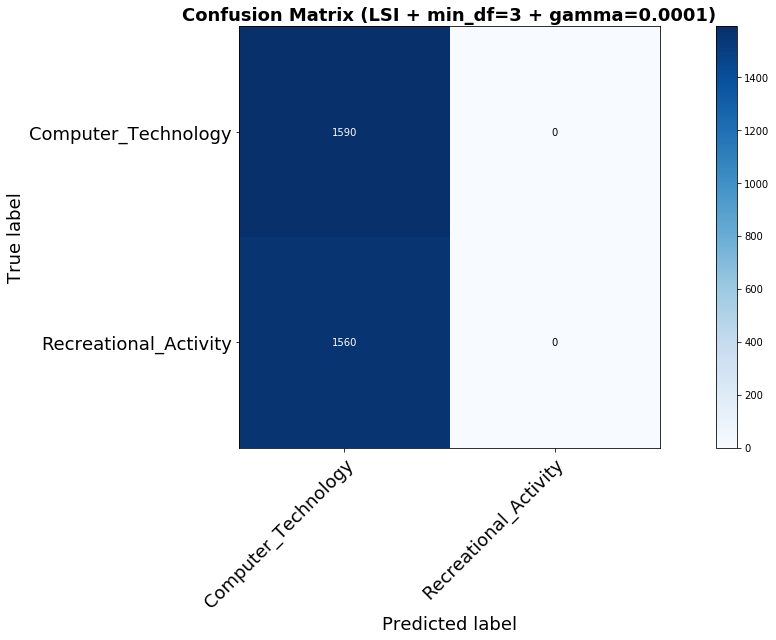

In [25]:
#Soft SVM r=0.0001
clf = svm.SVC(probability=True,gamma=0.0001)
clf.fit(X_train_reduced, target_train)
Y_predict = clf.predict(X_test_reduced)
#Calculate the probability estimates of the positive class
prob_data = clf.predict_proba(X_test_reduced)
prob_data = prob_data[:,1]
#Calculate fpr & ftr 
fpr,tpr,thresholds=metrics.roc_curve(target_test, prob_data)
fprs.append(fpr)
tprs.append(tpr)
print("-"*20+ " Hard-SVM "+"-"*20)
print("accuracy:",metrics.accuracy_score(target_test, Y_predict))
print("precision:",metrics.precision_score(target_test, Y_predict))
print("recall:",metrics.recall_score(target_test, Y_predict))
print("F-1 score:",f1_score(target_test, Y_predict))
conf_mat = metrics.confusion_matrix(target_test, Y_predict)
print("confusion matrix:",conf_mat)
plt.figure()
title = 'Confusion Matrix (LSI + min_df=3 + gamma=0.0001)'
class_names = np.array(['Computer_Technology', 'Recreational_Activity'])
plot_confusion_matrix(target_test, Y_predict ,classes=class_names,title=title)
plt.show()

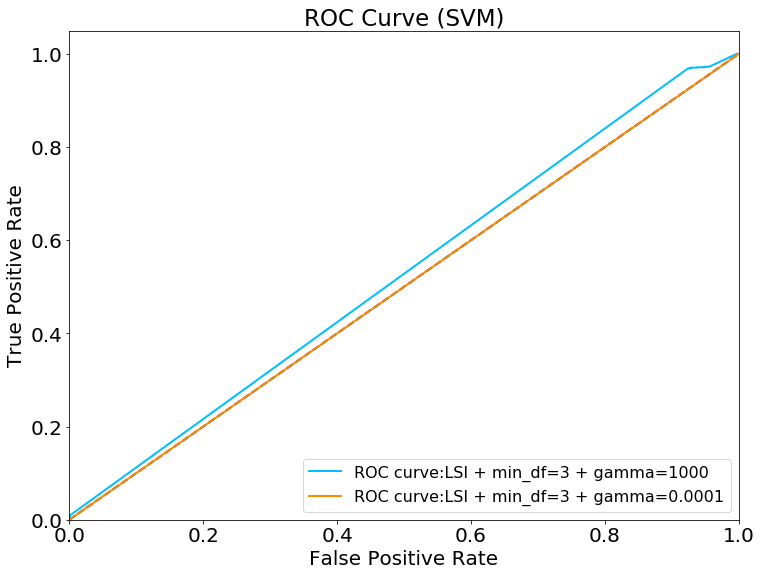

In [26]:
# plot ROC curve
plt.figure(figsize=(12,9))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('ROC Curve (SVM)', fontsize=23)
color = ['deepskyblue', 'darkorange']
r = [1000, 0.0001]
for i in range(2):
    plt.plot(fprs[i], tprs[i], color=color[i], lw=2, label='ROC curve:LSI + min_df=3 + gamma='+str(r[i]))
plt.legend(loc="lower right",fontsize=16)
plt.show()

In [11]:
#cross validation to select best r
from sklearn.model_selection import cross_val_score
r = [0.001,0.01,0.1,1,10,100,1000]
average_score = []
for gamma in r:
    clf = svm.SVC(gamma=gamma)
    scores = cross_val_score(clf, X_train_reduced, target_train, cv=5)
    average_score.append(scores.mean())
best_r = r[np.argmax(average_score)]
print('Best gamma is:',best_r)

Best gamma is: 1


-------------------- Best-SVM --------------------
accuracy: 0.9250793650793651
precision: 0.9715099715099715
recall: 0.8743589743589744
F-1 score: 0.9203778677462888
confusion matrix: [[1550   40]
 [ 196 1364]]


<Figure size 432x288 with 0 Axes>

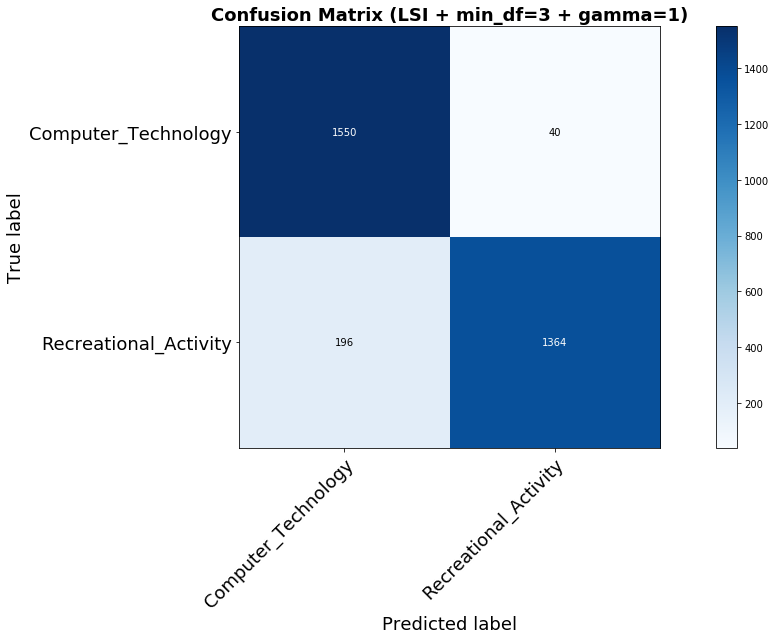

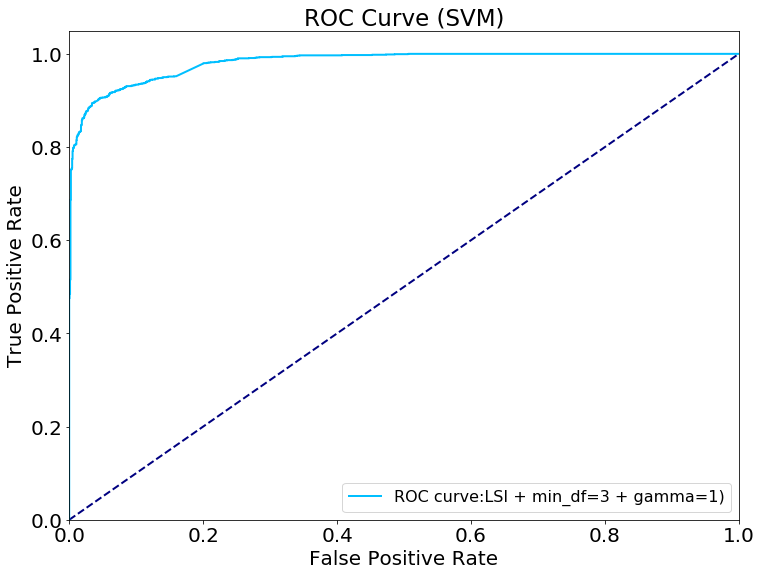

In [12]:
#Best SVM
clf = svm.SVC(probability=True,gamma=best_r)
clf.fit(X_train_reduced, target_train)
Y_predict = clf.predict(X_test_reduced)
#Calculate the probability estimates of the positive class
prob_data = clf.predict_proba(X_test_reduced)
prob_data = prob_data[:,1]
#Calculate fpr & ftr 
fpr,tpr,thresholds=metrics.roc_curve(target_test, prob_data)
print("-"*20+ " Best-SVM "+"-"*20)
print("accuracy:",metrics.accuracy_score(target_test, Y_predict))
print("precision:",metrics.precision_score(target_test, Y_predict))
print("recall:",metrics.recall_score(target_test, Y_predict))
print("F-1 score:",f1_score(target_test, Y_predict))
conf_mat = metrics.confusion_matrix(target_test, Y_predict)
print("confusion matrix:",conf_mat)
plt.figure()
title = 'Confusion Matrix (LSI + min_df=3 + gamma=' + str(best_r) + ')'
class_names = np.array(['Computer_Technology', 'Recreational_Activity'])
plot_confusion_matrix(target_test, Y_predict ,classes=class_names,title=title)
plt.show()

# plot ROC curve
plt.figure(figsize=(12,9))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('ROC Curve (SVM)', fontsize=23)
color = 'deepskyblue'
r = [1000, 0.0001]
plt.plot(fpr, tpr, color=color, lw=2, label='ROC curve:LSI + min_df=3 + gamma='+str(best_r)+')')
plt.legend(loc="lower right",fontsize=16)
plt.show()

#### Question 5: Logistic Regression

-------------------- Logistic Regression without regularization --------------------
accuracy: 0.5768253968253968
precision: 1.0
recall: 0.14551282051282052
F-1 score: 0.25405707890318974
confusion matrix: [[1590    0]
 [1333  227]]
/Users/rover/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

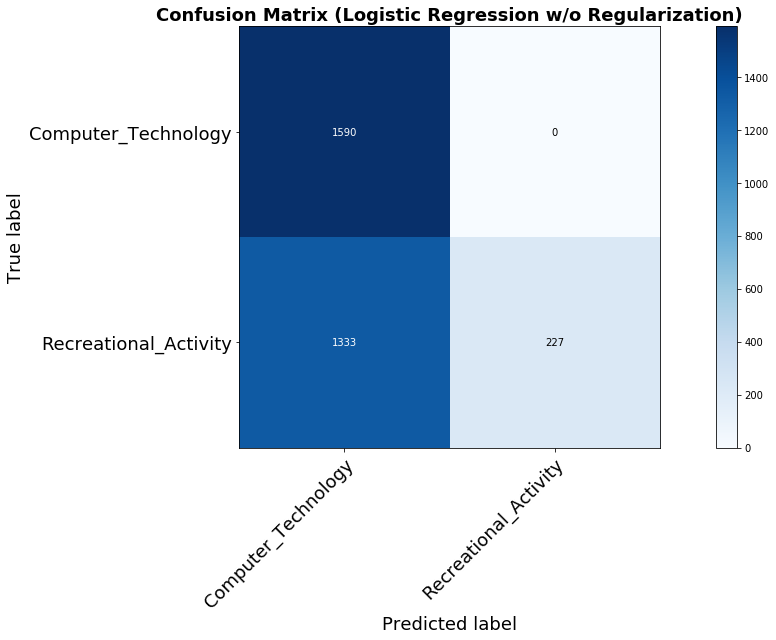

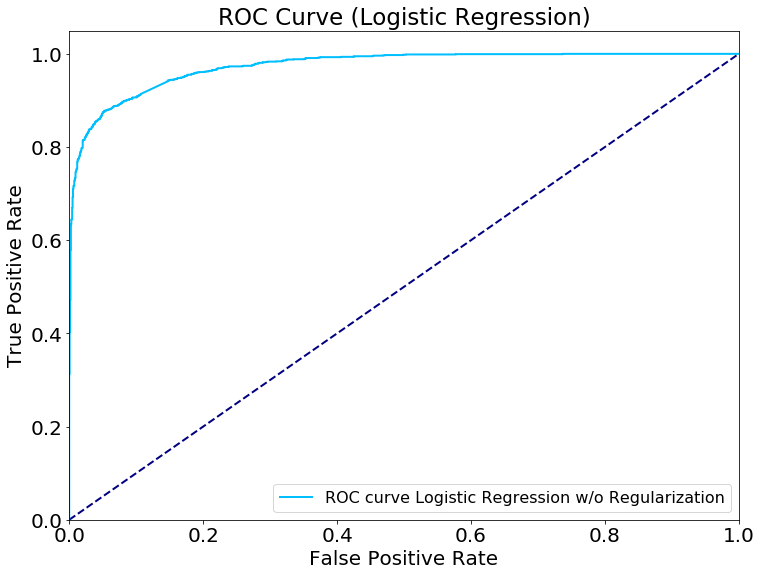

In [13]:
from sklearn.linear_model import LogisticRegression
#ROC
fprs = []#collect false positive
tprs = []#collect true positive

#Logistic Regression without Regularization
clf = LogisticRegression(C=1e-10) #remove regularization
clf.fit(X_train_reduced, target_train)
Y_predict = clf.predict(X_test_reduced)
#Calculate fpr & ftr 
fpr, tpr, thresholds = metrics.roc_curve(target_test, clf.predict_proba(X_test_reduced)[:, 1])
fprs.append(fpr)
tprs.append(tpr)
print("-"*20+ " Logistic Regression without regularization "+"-"*20)
print("accuracy:",metrics.accuracy_score(target_test, Y_predict))
print("precision:",metrics.precision_score(target_test, Y_predict))
print("recall:",metrics.recall_score(target_test, Y_predict))
print("F-1 score:",f1_score(target_test, Y_predict))
conf_mat = metrics.confusion_matrix(target_test, Y_predict)
print("confusion matrix:",conf_mat)
plt.figure()
title = 'Confusion Matrix (Logistic Regression w/o Regularization)'
class_names = np.array(['Computer_Technology', 'Recreational_Activity'])
plot_confusion_matrix(target_test, Y_predict ,classes=class_names,title=title)
plt.show()

# plot ROC curve
plt.figure(figsize=(12,9))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('ROC Curve (Logistic Regression)', fontsize=23)
color = 'deepskyblue'
r = [1000, 0.0001]
plt.plot(fpr, tpr, color=color, lw=2, label='ROC curve Logistic Regression w/o Regularization')
plt.legend(loc="lower right",fontsize=16)
plt.show()

In [14]:
#CV to find best L1 regularization
c = [0.001,0.01,0.1,1,10,100,1000]
average_score = []
for C in c:
    clf = LogisticRegression(penalty='l1',C=C)
    scores = cross_val_score(clf, X_train_reduced, target_train, cv=5)
    average_score.append(scores.mean())
best_C_l1 = c[np.argmax(average_score)]
print('Best regularization of L1 is:',best_C_l1)

/Users/rover/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rover/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rover/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rover/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rover/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs

In [15]:
#CV to find best L2 regularization
c = [0.001,0.01,0.1,1,10,100,1000]
average_score = []
for C in c:
    clf = LogisticRegression(penalty='l2',C=C)
    scores = cross_val_score(clf, X_train_reduced, target_train, cv=5)
    average_score.append(scores.mean())
best_C_l2 = c[np.argmax(average_score)]
print('Best regularization of L2 is:',best_C_l2)

/Users/rover/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rover/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rover/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rover/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rover/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs

In [17]:
#comparision of Logistic Regression
#Logistic Regression without Regularization
clf = LogisticRegression(C=1e-10) #remove regularization
clf.fit(X_train_reduced, target_train)
Y_predict = clf.predict(X_test_reduced)
print("-"*20+ " Logistic Regression without regularization "+"-"*20)
print("accuracy:",metrics.accuracy_score(target_test, Y_predict))
print("precision:",metrics.precision_score(target_test, Y_predict))
print("recall:",metrics.recall_score(target_test, Y_predict))
print("F-1 score:",f1_score(target_test, Y_predict))

#Logistic Regression with Best L1
clf = LogisticRegression(penalty='l1',C=10) # Best L1 Regularization
clf.fit(X_train_reduced, target_train)
Y_predict = clf.predict(X_test_reduced)
print("-"*20+ " Logistic Regression with Best L1 "+"-"*20)
print("accuracy:",metrics.accuracy_score(target_test, Y_predict))
print("precision:",metrics.precision_score(target_test, Y_predict))
print("recall:",metrics.recall_score(target_test, Y_predict))
print("F-1 score:",f1_score(target_test, Y_predict))

#Logistic Regression with Best L2
clf = LogisticRegression(penalty='l2',C=100) # Best L2 Regularization
clf.fit(X_train_reduced, target_train)
Y_predict = clf.predict(X_test_reduced)
print("-"*20+ " Logistic Regression with Best L2 "+"-"*20)
print("accuracy:",metrics.accuracy_score(target_test, Y_predict))
print("precision:",metrics.precision_score(target_test, Y_predict))
print("recall:",metrics.recall_score(target_test, Y_predict))
print("F-1 score:",f1_score(target_test, Y_predict))


-------------------- Logistic Regression without regularization --------------------
accuracy: 0.5768253968253968
precision: 1.0
recall: 0.14551282051282052
F-1 score: 0.25405707890318974
-------------------- Logistic Regression with Best L1 --------------------
accuracy: 0.9377777777777778
precision: 0.9608108108108108
recall: 0.9115384615384615
F-1 score: 0.9355263157894737
-------------------- Logistic Regression with Best L2 --------------------
accuracy: 0.9371428571428572
precision: 0.9613821138211383
recall: 0.9096153846153846
F-1 score: 0.9347826086956522
/Users/rover/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rover/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/U

#### Question 6: Naive Bayes

-------------------- Naive Bayes --------------------
accuracy: 0.7736507936507937
precision: 0.915603532875368
recall: 0.5980769230769231
F-1 score: 0.7235362543621559
confusion matrix: [[1504   86]
 [ 627  933]]


<Figure size 432x288 with 0 Axes>

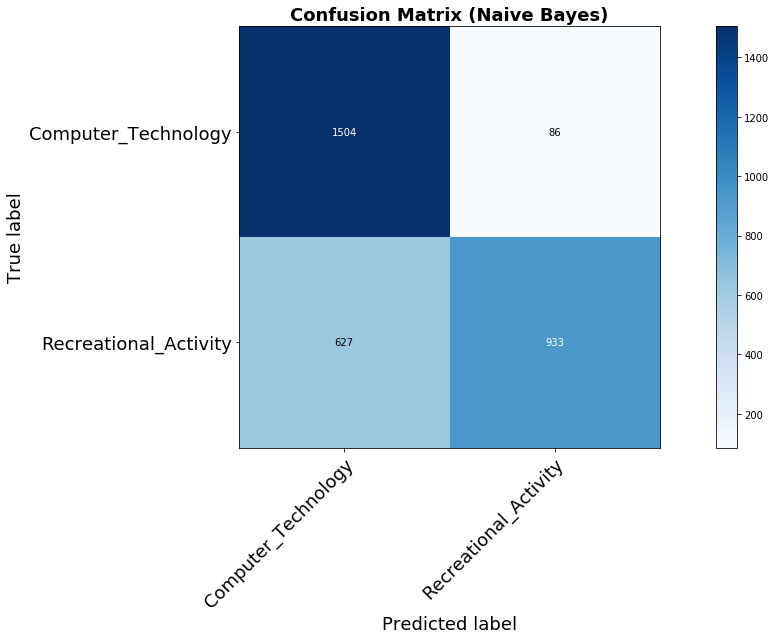

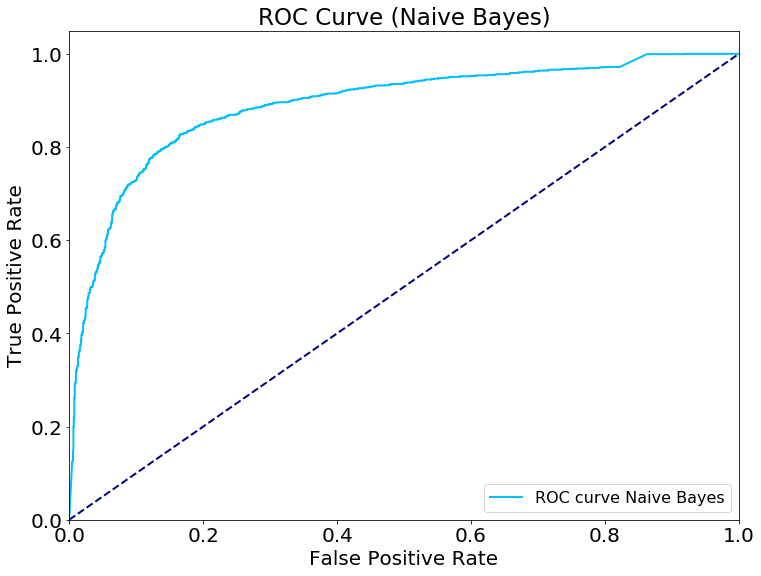

In [18]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB() #remove regularization
clf.fit(X_train_reduced, target_train)
Y_predict = clf.predict(X_test_reduced)
#Calculate fpr & ftr 
fpr, tpr, thresholds = metrics.roc_curve(target_test, clf.predict_proba(X_test_reduced)[:, 1])
fprs.append(fpr)
tprs.append(tpr)
print("-"*20+ " Naive Bayes "+"-"*20)
print("accuracy:",metrics.accuracy_score(target_test, Y_predict))
print("precision:",metrics.precision_score(target_test, Y_predict))
print("recall:",metrics.recall_score(target_test, Y_predict))
print("F-1 score:",f1_score(target_test, Y_predict))
conf_mat = metrics.confusion_matrix(target_test, Y_predict)
print("confusion matrix:",conf_mat)
plt.figure()
title = 'Confusion Matrix (Naive Bayes)'
class_names = np.array(['Computer_Technology', 'Recreational_Activity'])
plot_confusion_matrix(target_test, Y_predict ,classes=class_names,title=title)
plt.show()

# plot ROC curve
plt.figure(figsize=(12,9))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('ROC Curve (Naive Bayes)', fontsize=23)
color = 'deepskyblue'
r = [1000, 0.0001]
plt.plot(fpr, tpr, color=color, lw=2, label='ROC curve Naive Bayes')
plt.legend(loc="lower right",fontsize=16)
plt.show()